# Using ViewReturnMapping. A hands-on example.

In this notebook, the usage of the package `ViewReturnMapping` is illustrated.  
A problem typically presented in Finite Element Method classes, in the framework of computational plasticity, is solved.  
In the first place, let's present the problem.

## The problem

Consider a generic point in an isotropic solid with Young modulus $E=210$ GPa and Poisson ratio $\mu = 0.3$.  
The elastic stress-strain relation is defined by

$$
\begin{Bmatrix}
\sigma_{xx} \\ \sigma_{yy} \\ \sigma_{zz} \\ \sigma_{xy} \\ \sigma_{yz} \\ \sigma_{xz}
\end{Bmatrix}
=
\dfrac{E}{(1+\mu)(1-2\mu)}
\begin{bmatrix}
1-\mu & \mu & \mu & 0 & 0 & 0 \\
\mu & 1-\mu & \mu & 0 & 0 & 0 \\
\mu & \mu & 1-\mu & 0 & 0 & 0 \\
 0 & 0 & 0 & 1-2\mu & 0 & 0 \\
 0 & 0 & 0 & 0 & 1-2\mu & 0 \\
 0 & 0 & 0 & 0 & 0 & 1-2\mu
\end{bmatrix}
\begin{Bmatrix}
\varepsilon_{xx} \\ \varepsilon_{yy} \\ \varepsilon_{zz} \\ \varepsilon_{xy} \\ \varepsilon_{yz} \\ \varepsilon_{xz}
\end{Bmatrix}.
$$

The yielding behaviour of this material defined by a von Mises yield surface. The initial yield stress is $\sigma_{y0} = 240$ MPa.  
A Swift hardening law is employed:
$$
\sigma_y = K\left(e_0 + \bar{\varepsilon}^p\right)^n,
$$
with the parameters $e_0 = 0.15$ and $n = 0.0005$. The parameter $K$ is determined according to the initial yield stress:
$$
K = \dfrac{\sigma_{y0}}{e_0^n}.
$$

Consider that, at a given time step $n$, the stress state in the material point is defined by
$$
\boldsymbol{\sigma}_n =
\begin{bmatrix}
140 & 120 & 0 \\ 120 & 40 & 0 \\ 0 & 0 & 20
\end{bmatrix} \text{ MPa},
$$
and no plastic deformation has occured, i.e., $\bar{\varepsilon}^p=0$.  
An increment of deformation defined by
$$
\Delta\boldsymbol{\varepsilon} =
\begin{bmatrix}
0.0002 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0
\end{bmatrix}
$$
is applied to that material point.  
Determine the stress state obtained after the increment of deformation is applied.

## The solution with ViewReturnMapping

The solution of the problem described before is addressed in what follows, making use of the Python package `ViewReturnMapping`.  


### Initialisation of the material

This package has been implemented in an object-oriented framework. Therefore, an object that corresponds to the material presented in the problem must be created.  
The module `material` has to be imported in the first place.
Then, assuming that these properties correspond to a steel, let's create a variable `steel`.
The elastic properties must be provided in the initialisation, and it is a material of the class `isotropic`.

In [1]:
import material
# Define the material steel
# Tnitialise with elastic properties
steel = material.isotropic(E=210e9, mu=0.3)

The yield criteria and hardening law associated with the material are defined through the methods `set_yield_function` and `set_hardening_law`.

In [2]:
# Set the von Mises yield surface
steel.set_yield_function('vonMises', sigma_y0 = 240e6)
# Set the hardening law properties.
#  - for Linear hardening only H is needed: sigma_y = sigma_y0 + H*epbar
#  - for Swift hardening, define e_0 and n: sigma_y = K*(e_0 + epbar)^n, with K = sigma_y0/(e_0^n)
steel.set_hardening_law('Swift', n=0.15, e_0=0.0005)

### Initialisation of the stress state

The stress and strain tensors must be stored in _NumPy arrays_.
Let's store the initial stress state in a variable called `stress_n`.
We can check if the resulting equivalent stress complies with the assumption of no plastic strain by verifying if its value is lower than the initial yield stress.

In [3]:
# Define a stress tensor (must be numpy array)
import numpy as np
stress_n = 1.0e6 * np.array([[140, 120, 0],
                            [120, 40 , 0],
                            [0  ,0   ,20]])
# Get equivalent stress for this stress state
print('Equivalent stress is:')
print(steel.get_equiv_stress(stress_n))
print('Is it lower than the yield stress?')
print(steel.get_equiv_stress(stress_n) < steel.yield_func.sigma_y0 )

Equivalent stress is:
235796522.45103192
Is it lower than the yield stress?
True


Since it is verified, let's associate this stress state as the initial value of the stress, and set the initial accumulated plastic strain to zero.

In [4]:
# Set this stress state as the initial material state
steel.set_initial_stress(stress_n)
# and set the initial accumulated plastic strain as zero
steel.set_initial_epbar(0.0)

### Application of the increment of deformation

The incremental strain tensor is stored in the variable `DE` and it is applied to the material through the method `apply_increment_of_strain`.

In [5]:
# Define the incremental strain tensor
DE = np.array([[0.0002, 0, 0],
               [0     , 0, 0],
               [0     , 0, 0]])
# Apply it to the material
steel.apply_increment_of_strain(DE)

Assuming that the increment of deformation is purely elastic, the resulting stress state can be retrieved through the method `get_current_stress`. This is the trial stress tensor. We can check the corresponding equivalent stress and verify if it is lower than the yield stress.

In [6]:
# The current stress after applying the increment of strain, assuming elastic strain
stress_trial = steel.get_current_stress()
print('The trial stress tensor is')
print(stress_trial)
# And the corresponding equivalent stress is
print('The trial equivalent stress is')
print(steel.get_equiv_stress(stress_trial))
print('Is it lower than the yield stress?')
print(steel.get_equiv_stress(stress_trial) < steel.yield_func.sigma_y0)

The trial stress tensor is
[[1.96538462e+08 1.20000000e+08 0.00000000e+00]
 [1.20000000e+08 6.42307692e+07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.42307692e+07]]
The trial equivalent stress is
252490552.8726586
Is it lower than the yield stress?
False


### Return mapping

Since the trial stress state does not satisfy the yield criteria, the return mapping must be performed.  
It can be done by merely calling the method `return_mapping`.

In [7]:
# The stress state is not admissible. Therefore, lets perform the return mapping
steel.return_mapping()

----------------------------------------------------
Trial state:
Cauchy trial = 
[[1.96538462e+08 1.20000000e+08 0.00000000e+00]
 [1.20000000e+08 6.42307692e+07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.42307692e+07]]
Equivalent von Mises stress = 
252490552.8726586
von Mises yield function value = 
12490552.87265864
----------------------------------------------------
Iteration nr. 1
Dgamma^(1) = 3.9739889217954566e-05
res^(1) = 92166.37625190616
----------------------------------------------------
Iteration nr. 2
Dgamma^(2) = 4.003741504405441e-05
res^(2) = 4.701173961162567
----------------------------------------------------
Iteration nr. 3
Dgamma^(3) = 4.003743022164308e-05
res^(3) = 2.9802322387695312e-08
----------------------------------------------------
Final state:
epbar = 
4.003743022164308e-05
Cauchy = 
[[1.92893228e+08 1.15389272e+08 0.00000000e+00]
 [1.15389272e+08 6.56691588e+07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 4.64376134e+07]]
Equivalent von Mis

After the return mapping, the initial, trial, and current stress tensors can be recovered with the use of proper methods. For instance:

In [8]:
# Get the initial stress, trial stress and current stress
stress_old = steel.get_initial_stress()
stress_trial = steel.get_trial_stress()
stress_new = steel.get_current_stress()

### Visualisation of the return mapping

In order to visualise the impact of the return mapping procedure, we can plot the yield surfaces (initial and current) and the initial, trial and current stress states in the space of principal stresses (projected in the deviatoric plane).  
In the first place, we must import the `matplotlib.pyplot` package, and create the figure and axes.

<IPython.core.display.Javascript object>


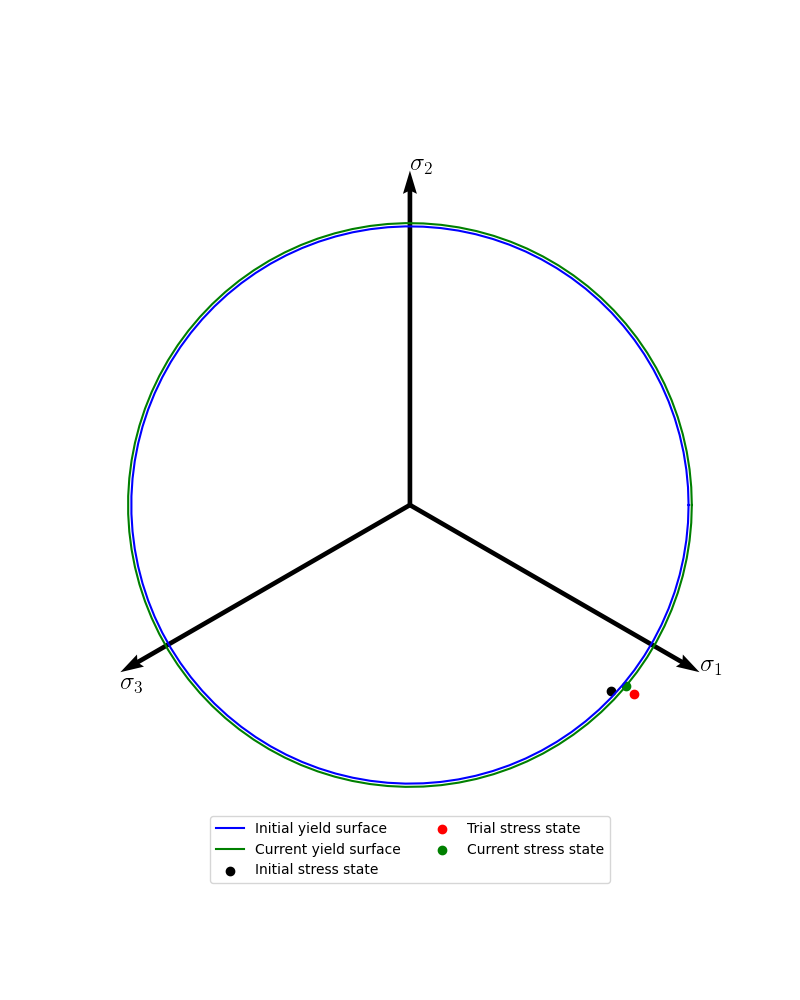

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,10))

The stress states are represented through the method `plot_yield_function`

In [10]:
# Plot the stress states
steel.plot_stress_state(ax, stress_old, color = 'black')
steel.plot_stress_state(ax, stress_trial, color = 'red')
steel.plot_stress_state(ax, stress_new, color = 'green')

The yield surface can be represented through the method `plot_yield_function`, which requires the axes object and yield stress. Additionally, the color for the plot can also be defined.

In [11]:
# Plot the initial yield surface
sigma_y0 = 240e6
steel.plot_yield_function(ax, sigma_y0, color = 'blue')

For the current yield surface, we need to determine the current yield stress that depends on the accumulated plastic strain. 

In [12]:
# Get the current accumulated plastic strain
epbar = steel.get_current_epbar()
# Determine the current yield stress
sigma_y = steel.hard_law.get_current_sigma_y(sigma_y0, epbar)
# Plot the current yield surface
steel.plot_yield_function(ax, sigma_y, color = 'green')

Make some final adjustments to the plot, add the principal stress axis with a scaling that exceeds the initial yield stress in 20%, add the legend, and generate the figure.

In [13]:
ax.axis('equal')
ax.axis('off')
steel.plot_princ_stress_axis(ax, scaling = 1.2*sigma_y0)
ax.legend(['Initial yield surface', 'Current yield surface', 'Initial stress state',
           'Trial stress state', 'Current stress state'], loc = 'lower center', ncol = 2)
plt.show()